## Импортируем нужные библиотеки, вспомогательные функции

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent
from misc import train_dqn, watch_agent, plot_scores

## Окружение

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
state_size = env.observation_space.shape
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size)
state_size = state_size[0]

State shape:  (8,)
Number of actions:  4


/home/dantatartes/miniconda3/envs/py3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Агенты

### Untrained agent

In [3]:
untrained_agent = Agent(state_size, action_size, seed=0)
watch_agent(untrained_agent, env)

В качестве baseline возьмём решение [Daniel T. Plop](https://github.com/plopd/deep-reinforcement-learning/tree/master/dqn)

### Default DQN

Episode 100	Average Score: -175.00
Episode 200	Average Score: -133.94
Episode 300	Average Score: -17.259
Episode 400	Average Score: 52.458
Episode 500	Average Score: 121.01
Episode 600	Average Score: 134.96
Episode 700	Average Score: 147.18
Episode 800	Average Score: 149.98
Episode 900	Average Score: 172.90
Episode 978	Average Score: 200.21
Environment solved in 878 episodes!	Average Score: 200.21


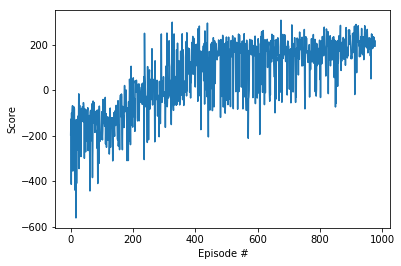

In [5]:
scores_default = train_dqn(untrained_agent, env, save_as='checkpoint_default')
plot_scores(scores_default)

### [Dueling DQN](https://arxiv.org/abs/1511.06581)

На интуитивном уровне, dueling-архитектура позволяет определять какие состояния выгодны (а какие нет), без обязанности просчитывать эффект каждого действия для каждого состояния. Это особенно полезно в состояниях где действия в нём не влияют на окружение в какой-либо мере.

![Dueling-DQN](files/img/dueling.png)

Нужно просто создать отдельный слой для V(s) и A(s, a),
затем сложить их в конце по формуле: Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))

In [4]:
agent = Agent(state_size, action_size, seed=0, dueling=True)
scores_dueling = train_dqn(agent, env, save_as='checkpoint_dueling')

Episode 100	Average Score: -174.46
Episode 200	Average Score: -91.466
Episode 300	Average Score: -21.61
Episode 400	Average Score: 81.974
Episode 500	Average Score: 87.057
Episode 600	Average Score: 128.93
Episode 700	Average Score: 152.99
Episode 799	Average Score: 200.11
Environment solved in 699 episodes!	Average Score: 200.11
